Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]



Training with activation: sigmoid
Epoch 1/5 | Loss: 2.0532 | Val Acc: 0.1937
Epoch 2/5 | Loss: 1.5148 | Val Acc: 0.4494
Epoch 3/5 | Loss: 1.0457 | Val Acc: 0.6361
Epoch 4/5 | Loss: 0.6985 | Val Acc: 0.8723
Epoch 5/5 | Loss: 0.3881 | Val Acc: 0.9135

Training with activation: tanh
Epoch 1/5 | Loss: 0.4642 | Val Acc: 0.9284
Epoch 2/5 | Loss: 0.2330 | Val Acc: 0.9521
Epoch 3/5 | Loss: 0.1830 | Val Acc: 0.9565
Epoch 4/5 | Loss: 0.1591 | Val Acc: 0.9615
Epoch 5/5 | Loss: 0.1480 | Val Acc: 0.9589

Training with activation: relu
Epoch 1/5 | Loss: 0.6078 | Val Acc: 0.9321
Epoch 2/5 | Loss: 0.2078 | Val Acc: 0.9203
Epoch 3/5 | Loss: 0.1580 | Val Acc: 0.9551
Epoch 4/5 | Loss: 0.1288 | Val Acc: 0.9664
Epoch 5/5 | Loss: 0.1133 | Val Acc: 0.9672

Training with activation: leakyrelu
Epoch 1/5 | Loss: 0.5762 | Val Acc: 0.9403
Epoch 2/5 | Loss: 0.1947 | Val Acc: 0.9514
Epoch 3/5 | Loss: 0.1532 | Val Acc: 0.9563
Epoch 4/5 | Loss: 0.1215 | Val Acc: 0.9682
Epoch 5/5 | Loss: 0.1104 | Val Acc: 0.9643


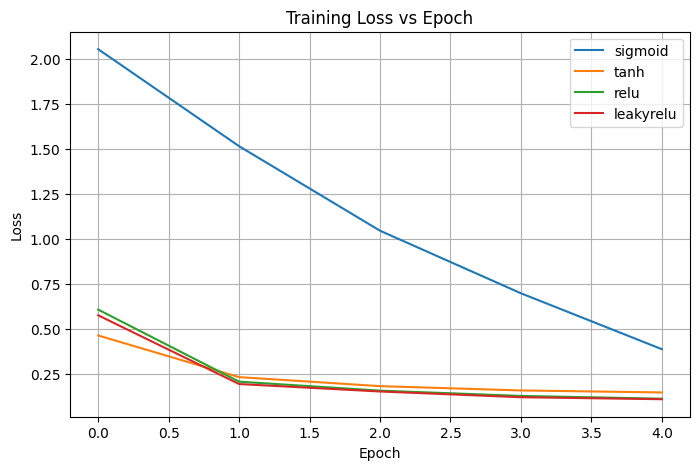

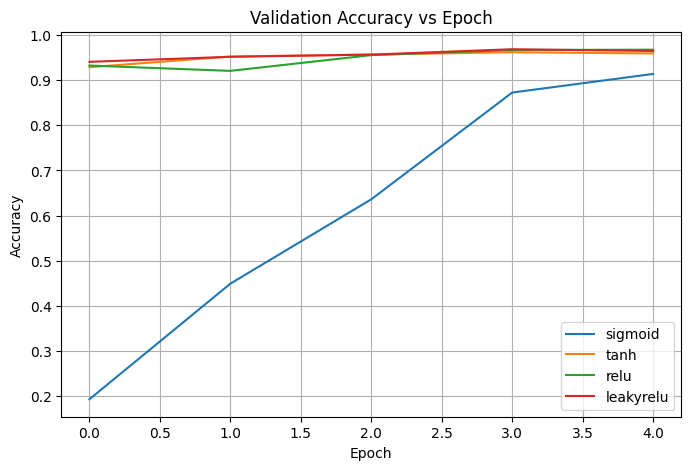

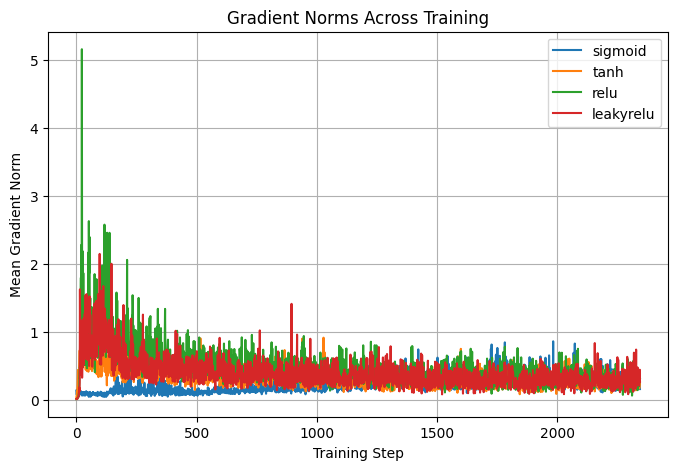

In [1]:
# ============================================================
# 1. IMPORTS
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ============================================================
# 2. DATA LOADING (MNIST)
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)


# ============================================================
# 3. MLP MODEL THAT ACCEPTS ANY ACTIVATION FUNCTION
# ============================================================
def get_activation(name):
    if name == "relu":
        return nn.ReLU()
    if name == "leakyrelu":
        return nn.LeakyReLU(0.01)
    if name == "tanh":
        return nn.Tanh()
    if name == "sigmoid":
        return nn.Sigmoid()
    raise ValueError("Unknown activation")


class DeepMLP(nn.Module):
    def __init__(self, activation_name="relu"):
        super().__init__()
        act = get_activation(activation_name)

        layers = []
        input_dim = 28*28
        hidden_dim = 256
        num_layers = 8

        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act)

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act)

        layers.append(nn.Linear(hidden_dim, 10))
        self.model = nn.Sequential(*layers)

        self.activation_name = activation_name

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


# ============================================================
# 4. TRAINING + GRADIENT NORM TRACKING
# ============================================================
def train_model(activation_name, epochs=5):
    model = DeepMLP(activation_name=activation_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loss_list = []
    val_acc_list = []
    grad_norms = []  # stores gradient norm per layer

    for epoch in range(epochs):
        model.train()
        batch_losses = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # -------- Gradient norm computation --------
            layer_norms = []
            for name, param in model.named_parameters():
                if "weight" in name:
                    layer_norms.append(param.grad.norm().item())
            grad_norms.append(np.mean(layer_norms))

            optimizer.step()
            batch_losses.append(loss.item())

        train_loss_list.append(np.mean(batch_losses))

        # Evaluate validation accuracy
        val_acc = evaluate(model)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss_list[-1]:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_loss_list, val_acc_list, grad_norms


# ============================================================
# 5. EVALUATION FUNCTION
# ============================================================
def evaluate(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


# ============================================================
# 6. RUN EXPERIMENTS FOR EACH ACTIVATION
# ============================================================
activations = ["sigmoid", "tanh", "relu", "leakyrelu"]

results = {}

for act in activations:
    print("\n==============================")
    print("Training with activation:", act)
    print("==============================")

    model, loss_curve, acc_curve, grad_curve = train_model(act, epochs=5)
    results[act] = {
        "loss": loss_curve,
        "accuracy": acc_curve,
        "gradients": grad_curve
    }


# ============================================================
# 7. PLOTTING RESULTS
# ============================================================

# Loss Curves
plt.figure(figsize=(8,5))
for act in activations:
    plt.plot(results[act]["loss"], label=act)
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Accuracy Curves
plt.figure(figsize=(8,5))
for act in activations:
    plt.plot(results[act]["accuracy"], label=act)
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Gradient Norms
plt.figure(figsize=(8,5))
for act in activations:
    plt.plot(results[act]["gradients"], label=act)
plt.title("Gradient Norms Across Training")
plt.xlabel("Training Step")
plt.ylabel("Mean Gradient Norm")
plt.legend()
plt.grid()
plt.show()
